<a href="https://colab.research.google.com/github/tutur90/Weather-Forecast/blob/main/Map_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np


#Local
path = 'data/mapdata_processed.csv'

#Colab
# path = 'https://raw.githubusercontent.com/tutur90/Weather-Forecast/main/data/mapdata/mapdata_processed.csv'


df = pd.read_csv(path, header=[0,1], index_col=[0,1])
df.head()
filters = df.columns.get_level_values(0).unique().to_list()
date = df.columns.get_level_values(1).unique().to_list()
filters, date

(['T_AVG_EH', 'T_AVG_ES', 'T_MAX_EH', 'T_MAX_ES', 'T_MIN_EH', 'T_MIN_ES'],
 ['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2013'])

<Axes: >

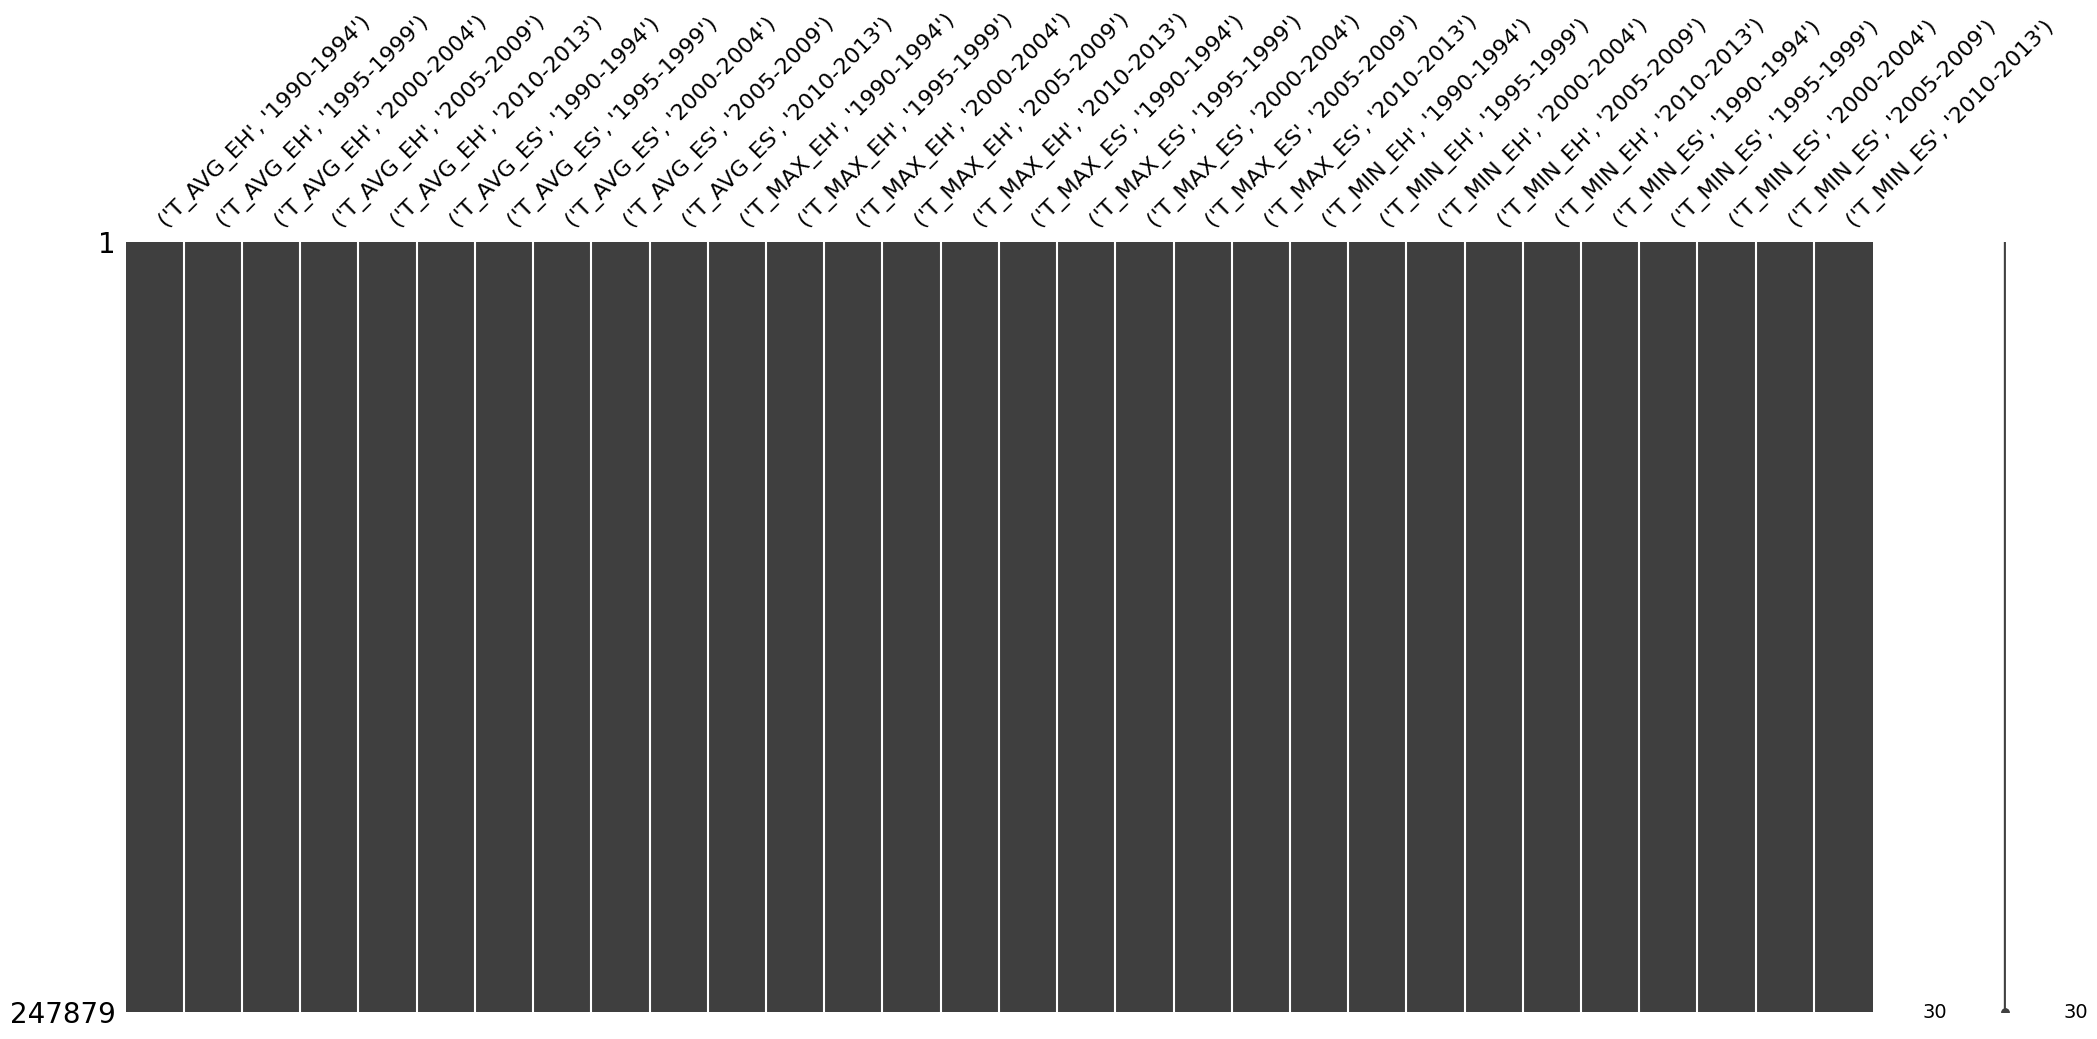

In [4]:
msno.matrix(df)

## Calcule the slope and the forcast point

In [5]:
from sklearn.linear_model import LinearRegression

years = np.array([int(year[-4:]) for year in date])

forcast_years = 5

if True:

    years_to_predict = np.concatenate((years, [years[-1] + forcast_years]))

    n_df = df.copy()

    for filter in filters:
        
        slopes = []
        next_5 = []

        for index, row in df[filter].iterrows():
            reg = LinearRegression().fit(years.reshape(-1, 1), row.values)
            slopes += [reg.coef_[0]]
            next_5 += [years_to_predict[-1]*reg.coef_[0]+reg.intercept_]
        n_df[(filter, 'slope')] = slopes
        n_df[(filter, 'prediction')] = next_5

    n_df.sort_index(axis=1, inplace=True)
    n_df.to_csv("data/mapdata/mapdata_forcast.csv")

    plt.scatter(years, row)
    predicted_line = years_to_predict*reg.coef_[0]+reg.intercept_
    plt.plot(years_to_predict, predicted_line)
    plt.scatter(years_to_predict[-1], predicted_line[-1])
    plt.xticks(years)
  

OSError: Cannot save file into a non-existent directory: 'data/mapdata'

## Plotting the slopes

In [1]:
n_df = pd.read_csv('data/mapdata_forcast.csv', header=[0,1], index_col=[0,1])

plt.figure(figsize=(14, 16))

print(filters.columns)

for i, filter in enumerate(filters):
    
    df_filter = n_df[(filter, 'slope')]

    abs_vmax = df_filter.abs().quantile(0.99)
    
    plt.subplot(3, 2, i+1)
    
    plt.scatter(df_filter.index.get_level_values(0), df_filter.index.get_level_values(1), c=df_filter, cmap='bwr', label='AVG {:.2E} °C/year'.format(df_filter.mean()), alpha=0.4, s=0.1, vmin=-abs_vmax, vmax=abs_vmax)
    plt.colorbar(label='°C/year')
    plt.title('Slopes of {} '.format(filter))

    plt.xlabel(n_df[filter].index.get_level_values(0).name)
    plt.ylabel(n_df[filter].index.get_level_values(1).name)
    plt.legend()


NameError: name 'pd' is not defined

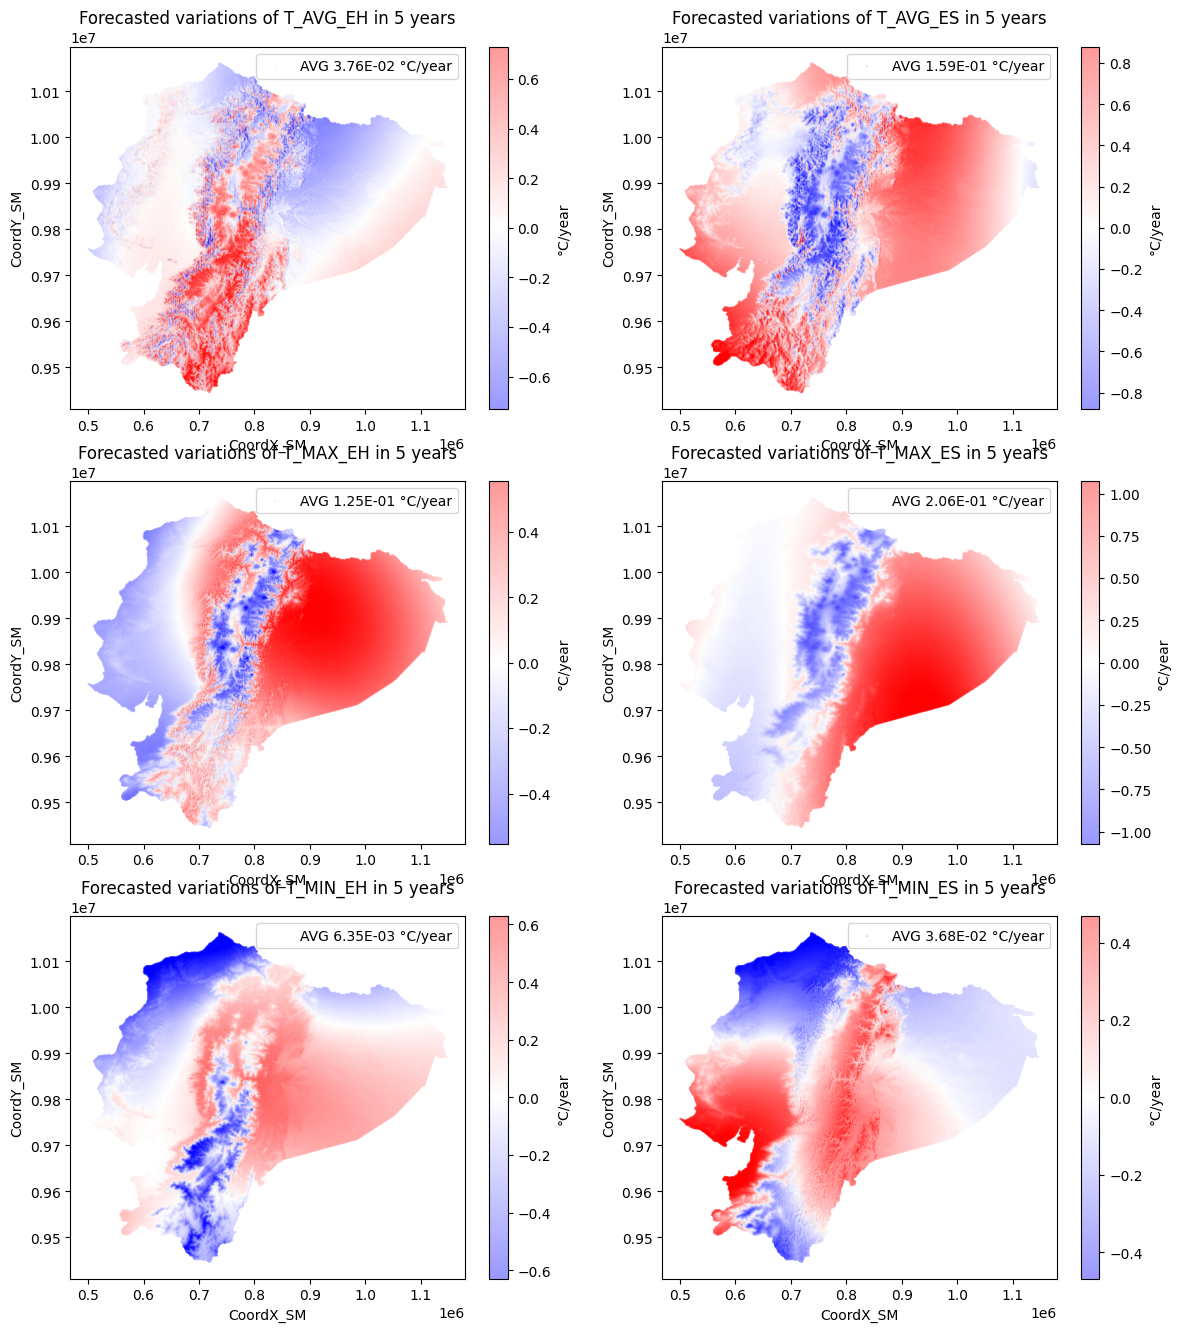

In [29]:

n_df = pd.read_csv('data/mapdata/mapdata_forcast.csv', header=[0,1], index_col=[0,1])


plt.figure(figsize=(14, 16))

for i, filter in enumerate(filters):
    
    df_filter = n_df[(filter,'prediction')]-n_df[(filter,'2010-2013')]

    abs_vmax = df_filter.abs().quantile(0.99)
    
    plt.subplot(3, 2, i+1)
    
    plt.scatter(df_filter.index.get_level_values(0), df_filter.index.get_level_values(1), c=df_filter, cmap='bwr', label='AVG {:.2E} °C/year'.format(df_filter.mean()), alpha=0.4, s=0.1, vmin=-abs_vmax, vmax=abs_vmax)
    plt.colorbar(label='°C/year')
    plt.title('Forecasted variations of {} in 5 years'.format(filter))

    plt.xlabel(df_filter.index.get_level_values(0).name)
    plt.ylabel(df_filter.index.get_level_values(1).name)
    plt.legend()

# Clusturing

In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


def cdbw_score(X, labels):
    """labels
    Parameters:
    X: Array-like, shape (n_samples, n_features). Input data.
    labels: Array-like, shape (n_samples,). Cluster labels for each sample.

    Returns:
    The CDbw index value.
    """
    n_samples, n_features = X.shape
    n_clusters = len(np.unique(labels))

    # Calculate cluster centers
    cluster_centers = np.zeros((n_clusters, n_features))
    for i in range(n_clusters):
        cluster_centers[i] = np.mean(X[labels == i], axis=0)

    # Calculate within-cluster dispersion
    within_cluster_dispersion = 0
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        cluster_center = cluster_centers[i]
        within_cluster_dispersion += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1))

    within_cluster_dispersion /= n_samples

    # Calculate between-cluster dispersion
    between_cluster_dispersion = 0
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            distance = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
            between_cluster_dispersion += distance

    between_cluster_dispersion /= (n_clusters * (n_clusters - 1)) / 2

    # Compute CDbw index
    cdbw = within_cluster_dispersion / between_cluster_dispersion

    return cdbw

def get_eval_metric(metric_name):
    if metric_name == 'silhouette':
        eval_metric = silhouette_score
    elif metric_name == 'calinski_harabasz':
        eval_metric = calinski_harabasz_score
    elif metric_name == 'davies_bouldin':
        eval_metric = davies_bouldin_score
    elif metric_name == 'cdbw':
        eval_metric = cdbw_score
    else:
        raise ValueError(f"Unknown evaluation metric: {metric_name}")
    return eval_metric

In [11]:
dfc = pd.read_csv('data/mapdata_forcast.csv', header=[0,1], index_col=[0,1])


InvalidIndexError: (slice(None, None, None), [('T_AVG_EH', 'slope')])

In [14]:
dfc.loc[:,('T_AVG_EH','slope')]

CoordX_SM    CoordY_SM 
500238.433   9757716.35   -0.047470
501238.433   9756716.35   -0.048646
             9757716.35   -0.046875
502238.433   9755716.35   -0.047362
             9756716.35   -0.048637
                             ...   
1145238.433  9892716.35    0.000661
             9893716.35    0.000554
1146238.433  9891716.35    0.000141
             9892716.35    0.000261
1147238.433  9891716.35    0.000294
Name: (T_AVG_EH, slope), Length: 247879, dtype: float64

In [21]:
dfc.loc[:,pd.IndexSlice[['T_AVG_EH','T_MAX_EH','T_MIN_EH'],'slope']]

T_AVG_EH  T_MAX_EH  T_MIN_EH
                           slope     slope     slope
CoordX_SM   CoordY_SM                               
500238.433  9757716.35 -0.047470 -0.012067 -0.072063
501238.433  9756716.35 -0.048646 -0.011388 -0.072182
            9757716.35 -0.046875 -0.011957 -0.071786
502238.433  9755716.35 -0.047362 -0.010952 -0.072170
            9756716.35 -0.048637 -0.010986 -0.072012
...                          ...       ...       ...
1145238.433 9892716.35  0.000661  0.036916 -0.007846
            9893716.35  0.000554  0.036884 -0.007873
1146238.433 9891716.35  0.000141  0.037308 -0.007838
            9892716.35  0.000261  0.037188 -0.007914
1147238.433 9891716.35  0.000294  0.037344 -0.008034

[247879 rows x 3 columns]

In [13]:
import numpy as np
import pandas as pd
import itertools
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans

run = True

if run:

    dfc = pd.read_csv('data/mapdata/mapdata_forcast.csv', header=[0,1], index_col=[0,1])

    test_clusters = 20

    metrics = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'cdbw'] # Choose the metrics evaluation

    scalers = ['Standard'] # Choose the scalers to apply ['Standard', 'MinMax', 'None']
    
    modes = ['spacial', 'normal'] # Choose the modes to apply ['spacial', 'normal']
    
    col_used = 
    
    n_filters = filters + ['All']

    list_params = list(itertools.product([modes, scalers, n_filters]))

    results = []

    labels = []

    for n, (mode, scaler, filter) in tqdm(enumerate(list_params), total=len(list_params)):
        
        if mode == 'normal':
            dfcf = dfc[filter] if filter != 'All' else dfc
        else:
            dfcf = dfc.reset_index().loc[:, pd.IndexSlice[[filter, 'CoordX_SM', 'CoordY_SM'], :]] if filter != 'All' else dfc.reset_index()
            
        if scaler != 'None':
            if scaler == 'MinMax':
                used_scaler = MinMaxScaler()
            else:
                used_scaler = StandardScaler()
            dfcs = pd.DataFrame(used_scaler.fit_transform(dfcf), columns=dfc.columns)
        else:
            dfcs = dfcf
        
        for cluster in tqdm(range(2,test_clusters+1, 2)):
            clust = KMeans(n_clusters=cluster, n_init='auto')
            clust.fit_predict(dfcs)

            labels.append({'mode': mode, 'filter': filter, 'scaler': scaler, 'num_clusters': cluster, 'labels': clust.labels_})
            for metric in metrics:
                results.append({'mode': mode,'metric': metric, 'scaler': scaler, 'filter': filter,  'num_clusters': cluster, 'score': get_eval_metric(metric)(dfcs, clust.labels_)})
            

    results = pd.DataFrame(results)

    df_labels = pd.concat([pd.DataFrame(labels[i], index=dfc.index) for i in range(len(labels))]) 

    df_labels.to_csv('data/mapdata/kmeans_labels.csv')

    results['scaled_score'] = results.groupby('metric')['score'].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).reshape(-1))
    results.to_csv('data/mapdata/kmeans_results.csv')
    results

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_843961/3146207811.py:5: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.relplot(


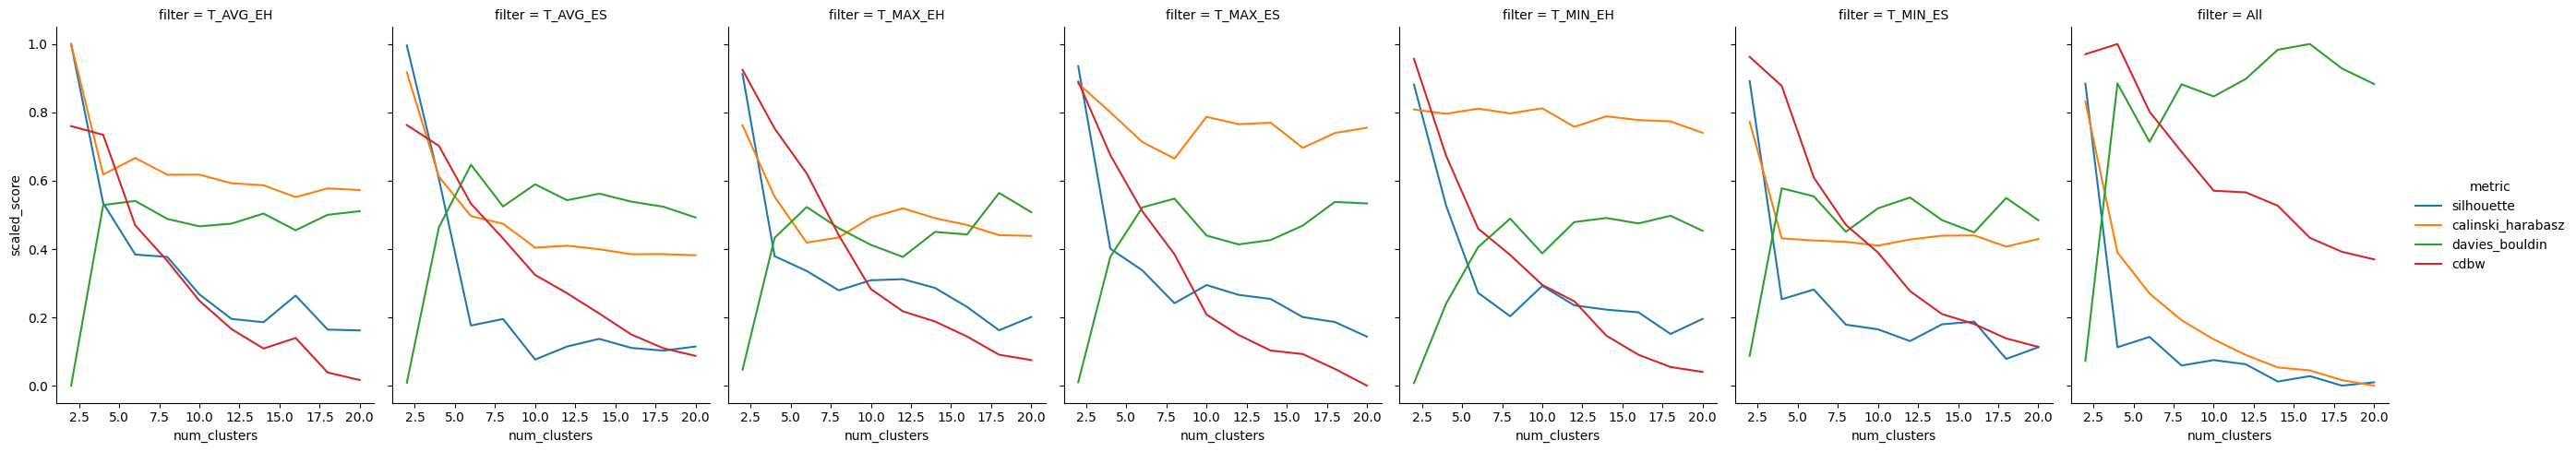

In [18]:
import seaborn as sns

results = pd.read_csv('data/mapdata/kmeans_results.csv')

sns.relplot(
    data=results,
    x='num_clusters',
    y="scaled_score",
    hue="metric",
    row='mode',
    col="filter",
    # size='scaler',
    kind="line", palette=sns.color_palette("tab10"),
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

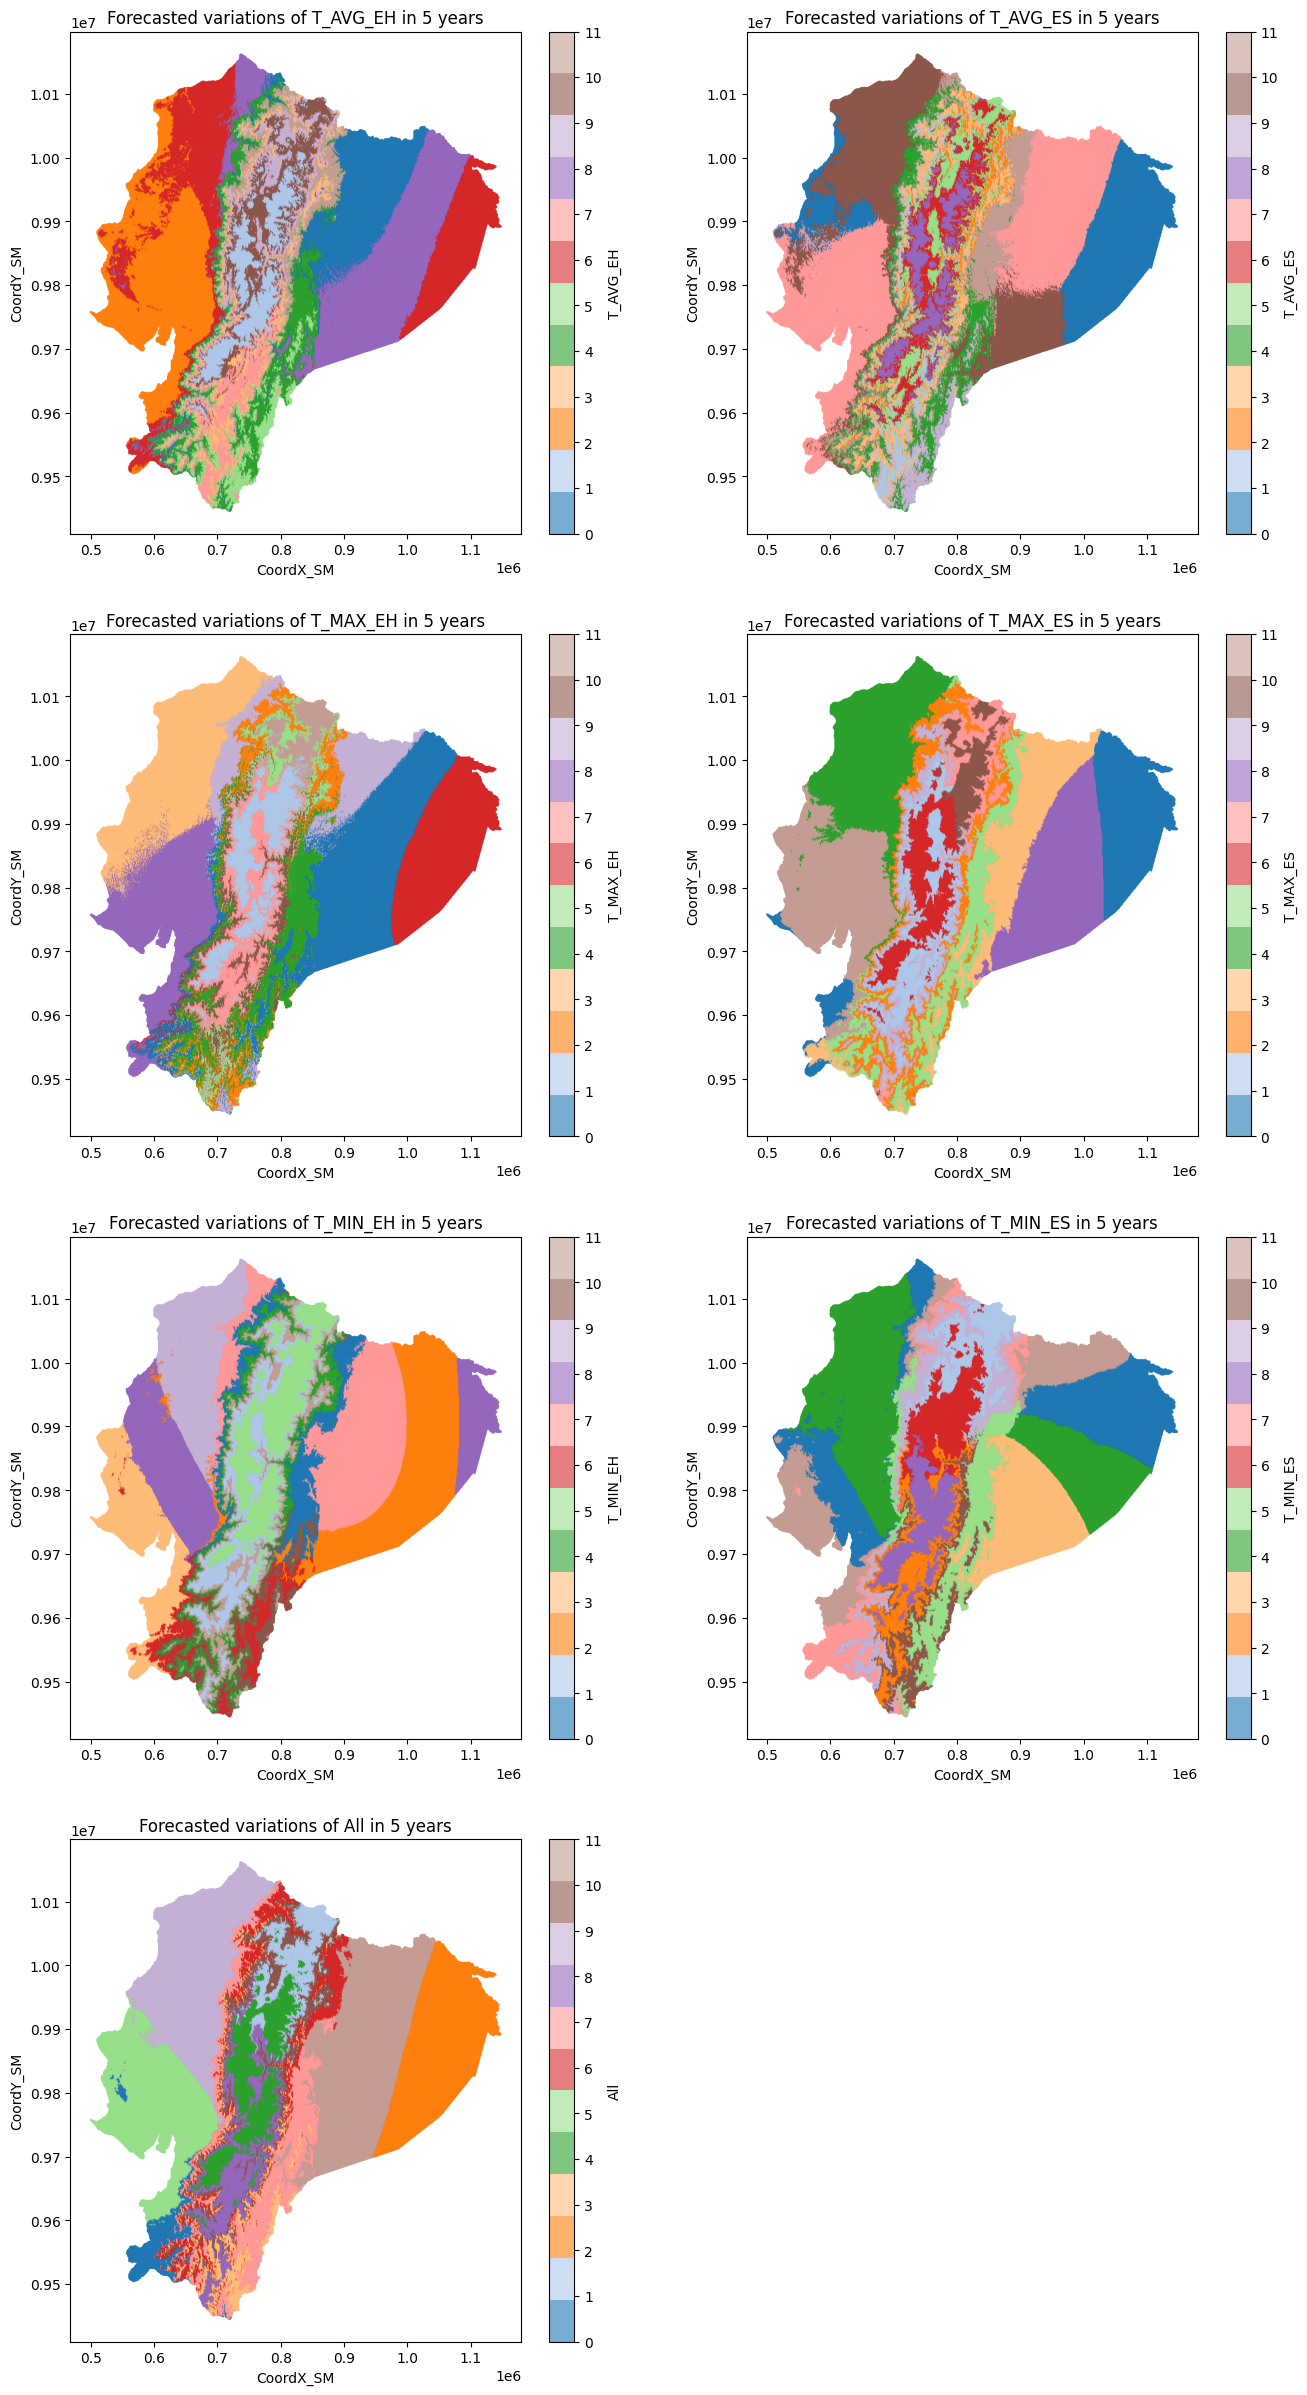

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

df_labels = pd.read_csv('data/mapdata/kmeans_labels.csv', index_col=[0,1])

n_filters = filters + ['All']

num_clusters = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20] # Choose the numbers of clusters to plot

mode = ['spacial', 'normal'] # Choose the modes to apply ['spacial', 'normal']


for (mode, num_clusters) in itertools.product(['spacial', 'normal'], n_filters): # For each mode and number of clusters, plot another figure
    
    plt.figure(figsize=(16, 5*len(filters)))
    
    for filter in n_filters: # For each filter, plot a subplot in the same figure
        
        l = df_labels[(df_labels['filter'] == filter) & (df_labels['num_clusters'] == num_clusters)]

        plt.subplot(len(filters)//2+1, 2, n_filters.index(filter)+1)
        
        plt.scatter(l.index.get_level_values('CoordX_SM'), l.index.get_level_values('CoordY_SM'), c=l['labels'], 
                    cmap=ListedColormap(sns.color_palette("tab20", num_clusters).as_hex()), alpha=0.6, s=0.5)
        

        plt.xlabel('CoordX_SM')
        plt.ylabel('CoordY_SM')
        plt.title('Cluster of {} in 5 years'.format(filter))
        plt.colorbar(label=filter, ticks=range(num_clusters))
    plt.show()
    plt.savefig('image/kmeans_{}_{}.png'.format(mode, num_clusters))

Text(0, 0.5, 'Feature Name')

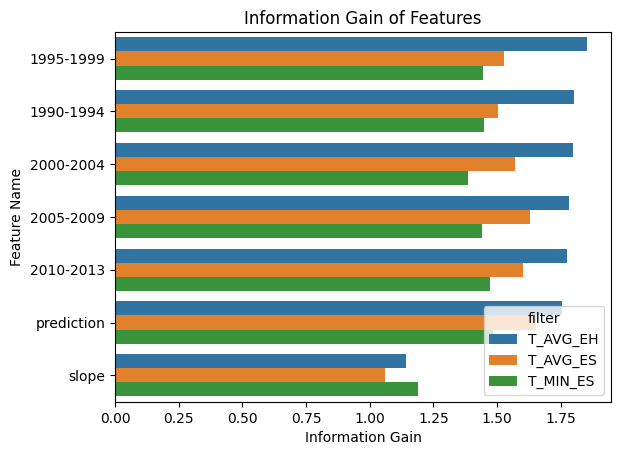

In [8]:
from sklearn.feature_selection import mutual_info_classif



num_clusters = 16

filters = ['T_AVG_EH', 'T_AVG_ES', 'T_MIN_ES']  


df_labels = pd.read_csv('data/mapdata/kmeans_labels.csv', index_col=[0,1])
df = pd.read_csv('data/mapdata/mapdata_forcast.csv', header=[0,1], index_col=[0,1])
df = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)

igs = []

for filter in filters:

    ig = mutual_info_classif(df[filter], df_labels[(df_labels['filter'] == filter) & (df_labels['num_clusters'] == num_clusters)]['labels'])
    ig = pd.DataFrame(ig, index=df[filter].columns, columns=['Gain']).sort_values(ascending=False, by='Gain')

    ig['filter'] = filter

    igs.append(ig)
    
igs = pd.concat(igs, axis=0)

sns.barplot(x='Gain', y=igs.index, data=igs, hue='filter')
plt.title('Information Gain of Features')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')

In [10]:
from sklearn.feature_selection import mutual_info_classif

num_clusters = 2

df_labels = pd.read_csv('data/mapdata/kmeans_labels_spacial.csv', index_col=[0,1])
df = pd.read_csv('data/mapdata/mapdata_forcast.csv', header=[0,1], index_col=[0,1])

df = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)

igs = []

for filter in filters:

    ig = mutual_info_classif(df[filter].reset_index(), df_labels[(df_labels['filter'] == filter) & (df_labels['num_clusters'] == num_clusters)]['labels'])
    ig = pd.DataFrame(ig, index=df[filter].reset_index().columns, columns=['Gain']).sort_values(ascending=False, by='Gain')

    ig['filter'] = filter

    igs.append(ig)
    
igs = pd.concat(igs, axis=0)

sns.barplot(x='Gain', y=igs.index, data=igs, hue='filter', palette='virilis')
plt.title('Information Gain of Features')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')